# Phân loại bình luận tích cực và tiêu cực trên các quán ăn

In [123]:
import pandas as pd
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [47]:
df = pd.read_csv('data_1.csv')
df['Label'] = df['Point'].apply(lambda point: 0 if point >= 5 else 1)
sentences = df['Review'].tolist()
joined_sentences = " ".join(sentences)

## Khai phá dữ liệu

### Dữ liệu

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  1181 non-null   object 
 1   Point   1181 non-null   float64
 2   Label   1181 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.8+ KB


In [131]:
df.describe()

,Point,Label
count,1181.000000,1181.000000
mean,7.174259,0.126164
std,1.986535,0.332175
min,1.000000,0.000000
25%,6.800000,0.000000
50%,7.600000,0.000000
75%,8.200000,0.000000
max,10.000000,1.000000


In [132]:
df

,Review,Point,Label
0,"Cháo ếch đậm đà, cơm thì không đặc sắc mấy. \n...",7.4,0
1,Quán này mình cũng hay order lắm. Menu quán cũ...,7.8,0
2,Cháo thịt bò 30k\n------\nĐang mệt người vì th...,8.0,0
3,"Shinshu đã chuyển qua nguỹen hoàng, vị trí cũn...",8.0,0
4,"Chất lượng : Menu đa dạng , nhiều lựa chọn , t...",8.2,0
...,...,...,...
1176,Đi mua đồ ở gần chợ tam giác nên tiện ghé vào ...,7.4,0
1177,"Trời nóng, mấy mẹ con đi dạo rồi ghé vào ăn ch...",8.0,0
1178,Mình thấy quán này cũng bình thường...chắc mìn...,5.0,0
1179,Quán này cũng rất nổi tiếng. \nNhiều chi nhánh...,8.2,0


[Text(0.5, 1.0, 'Số lượng mẫu')]

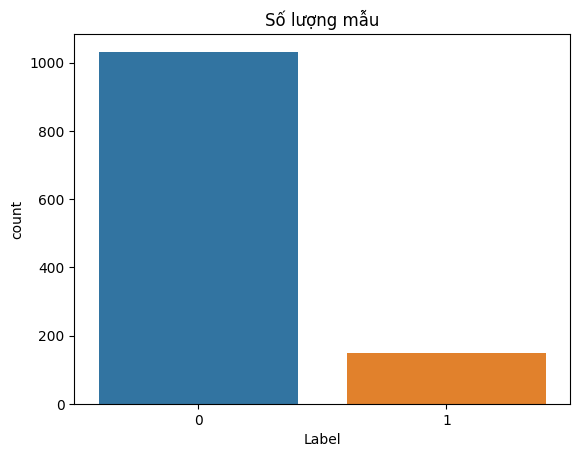

In [142]:
sns.countplot(data=df, x='Label').set(title='Số lượng mẫu')

### WordCloud trước khi tiền xử lý

- <i>WordCloud của tất cả các review</i>

In [48]:
def plot_wordcloud(sentences):
    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(max_words=200, background_color='white').generate(sentences)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

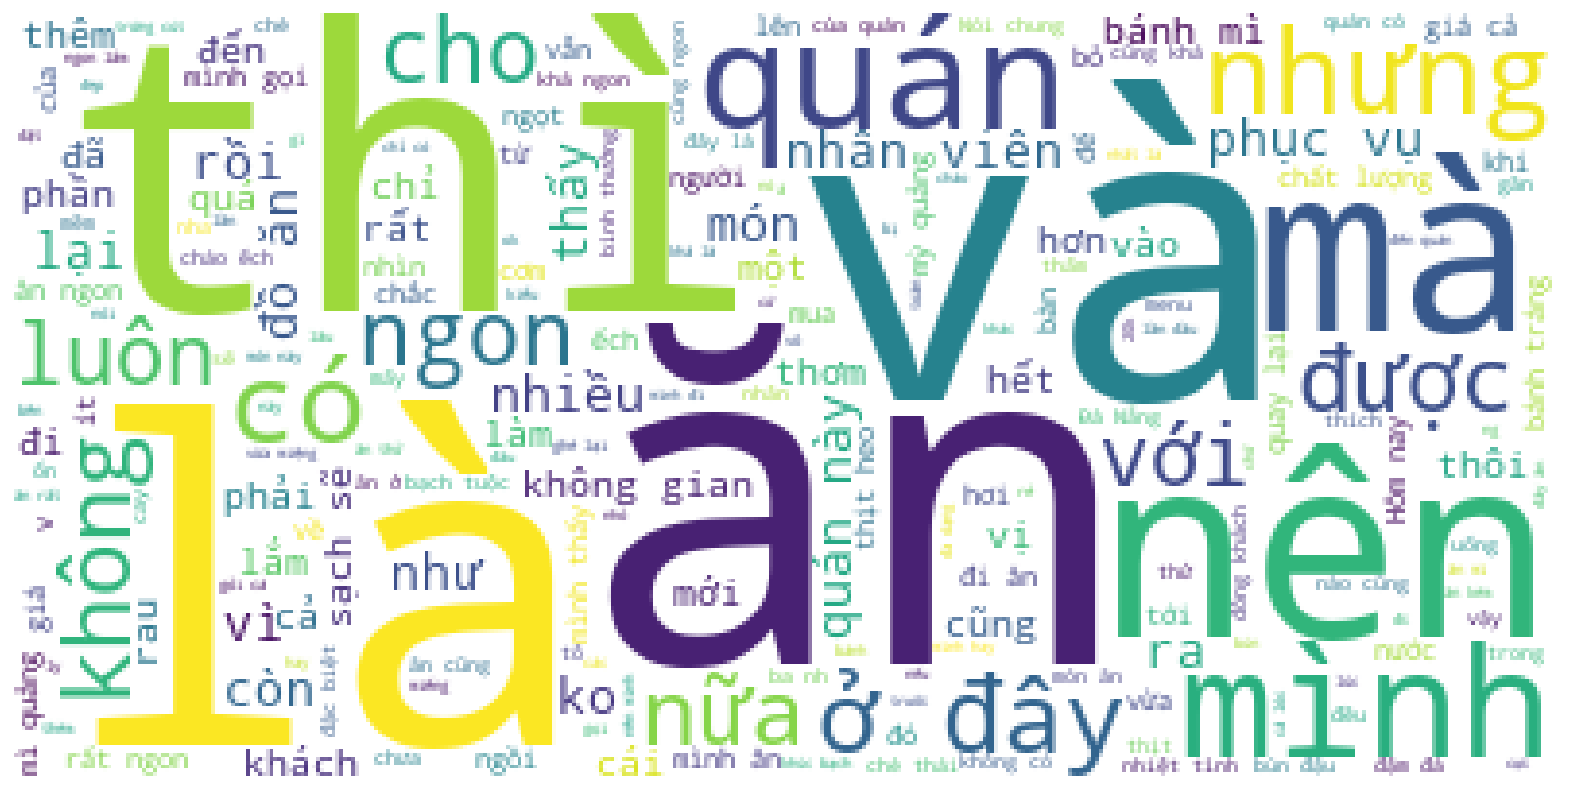

In [49]:
plot_wordcloud(joined_sentences)

In [50]:
negative = df[df['Label'] == 1]
positive = df[df["Label"] == 0]

negative_sentences = " ".join(negative['Review'].tolist())
positive_sentences = " ".join(positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

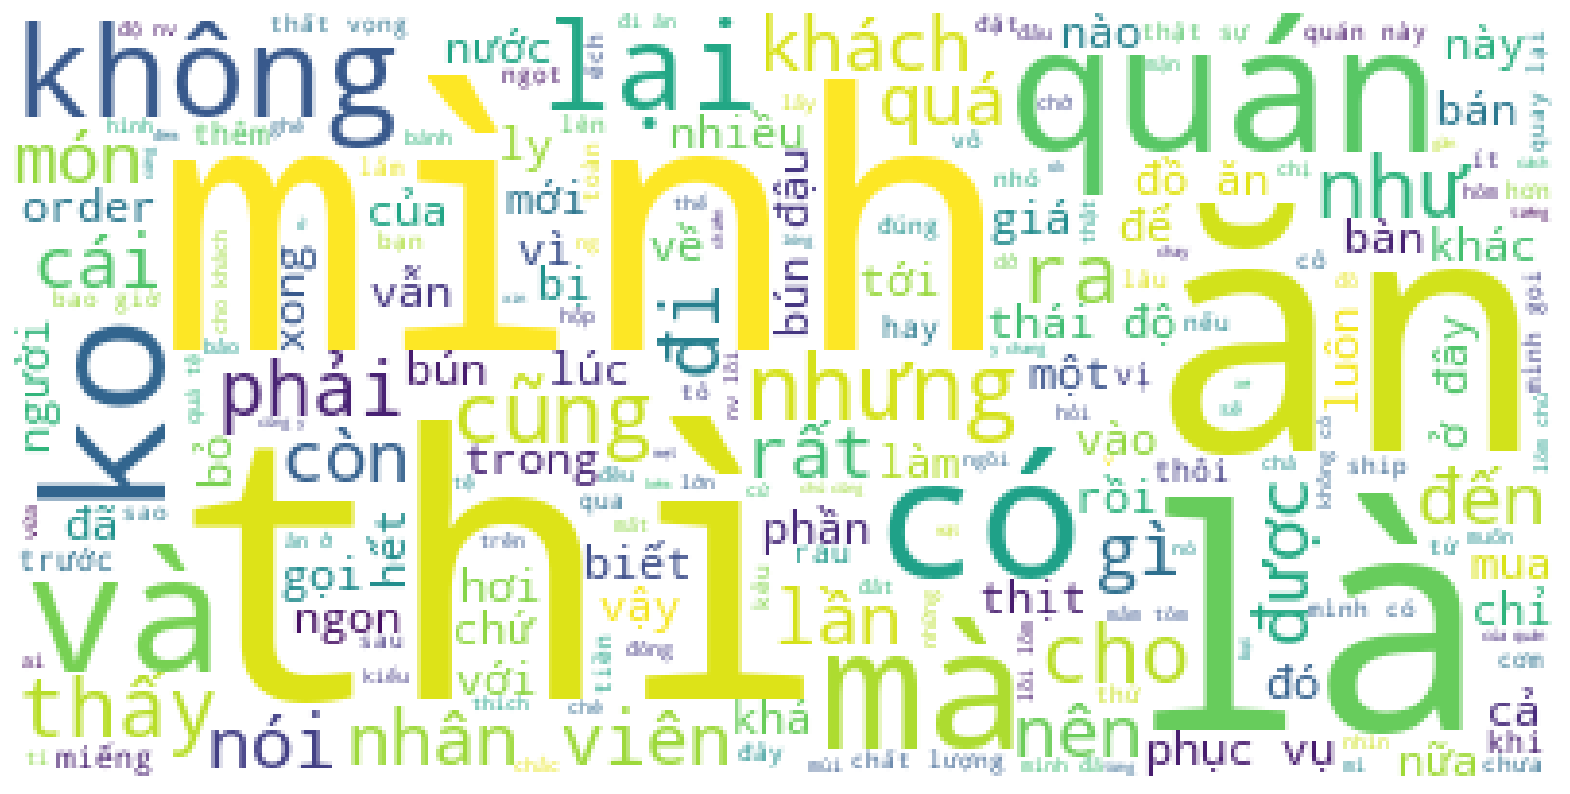

In [51]:
plot_wordcloud(negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

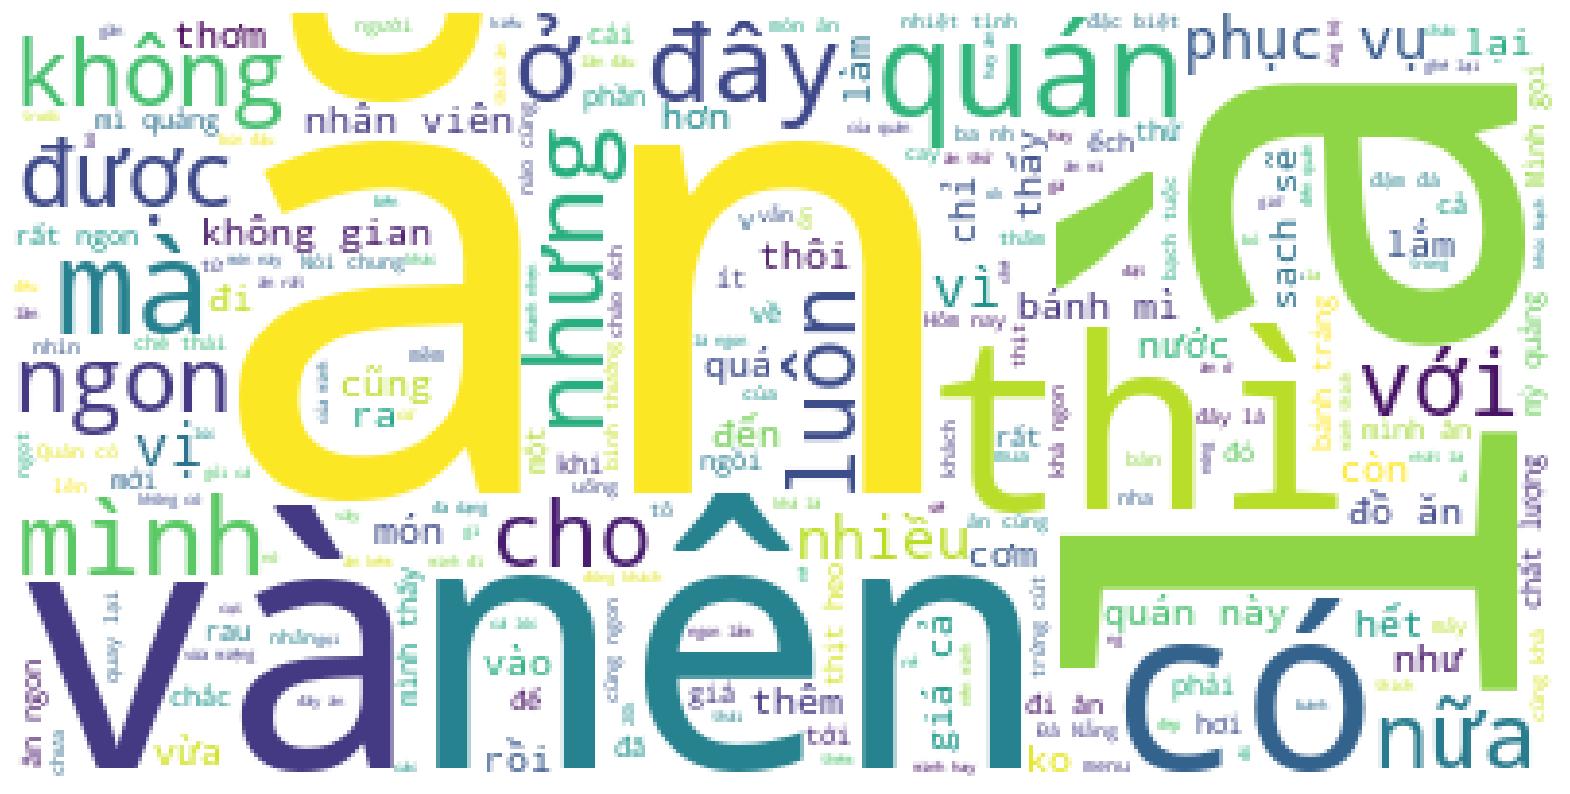

In [52]:
plot_wordcloud(positive_sentences)

### WordCloud sau khi tiền xử lý

Hàm tiền xử lý chuỗi

In [90]:
def tokenize_vietnamese_text(text):
    tokens = ViTokenizer.tokenize(text)
    return tokens


def get_stopwords(url):
    with open(url, 'r+', encoding='utf8') as file:
        stopwords = file.readlines()
        return set(stopwords)
    
    
stopwords = get_stopwords('vietnamese_stopwords_dash.txt')
def review_cleaning(message):
    # chuyển hết chuỗi sang chữ thường
    message = message.lower()
    
    # xoá các kí tự đặc biệt
    removed_punc_str = [char for char in message if char not in string.punctuation]
    removed_punc_str = ''.join(removed_punc_str)

    # tách các từ ghép
    removed_punc_str = tokenize_vietnamese_text(removed_punc_str)

    # xoá các stopwords
    clean_removed_punc_str = [word for word in removed_punc_str.split() if word.lower() not in stopwords]
    return clean_removed_punc_str

In [91]:
def list_to_str(message):
    return " ".join(message)

In [92]:
clean_df = pd.DataFrame(df['Review'].apply(review_cleaning))
clean_df['Review'] = clean_df['Review'].apply(list_to_str)
clean_df['Label'] = df['Label']

clean_sentences = " ".join(clean_df['Review'].tolist())

In [93]:
print(clean_df['Review'])

0       cháo ếch đậm_đà cơm thì không đặc_sắc mấy chủ ...
1       quán này mình cũng hay order lắm menu quán cũn...
2       cháo thịt bò 30k đang mệt người vì thời_tiết đ...
3       shinshu đã chuyển qua nguỹen hoàng vị_trí cũng...
4       chất_lượng menu đa_dạng nhiều lựa_chọn từ hươn...
                              ...                        
1176    đi mua đồ ở gần chợ tam_giác nên tiện ghé vào ...
1177    trời nóng mấy mẹ con đi dạo rồi ghé vào ăn chè...
1178    mình thấy quán này cũng bình thườngchắc mình k...
1179    quán này cũng rất nổi_tiếng nhiều chi_nhánh từ...
1180    có dịp vào đà_nẵng không_thể không ghé vào ăn ...
Name: Review, Length: 1181, dtype: object


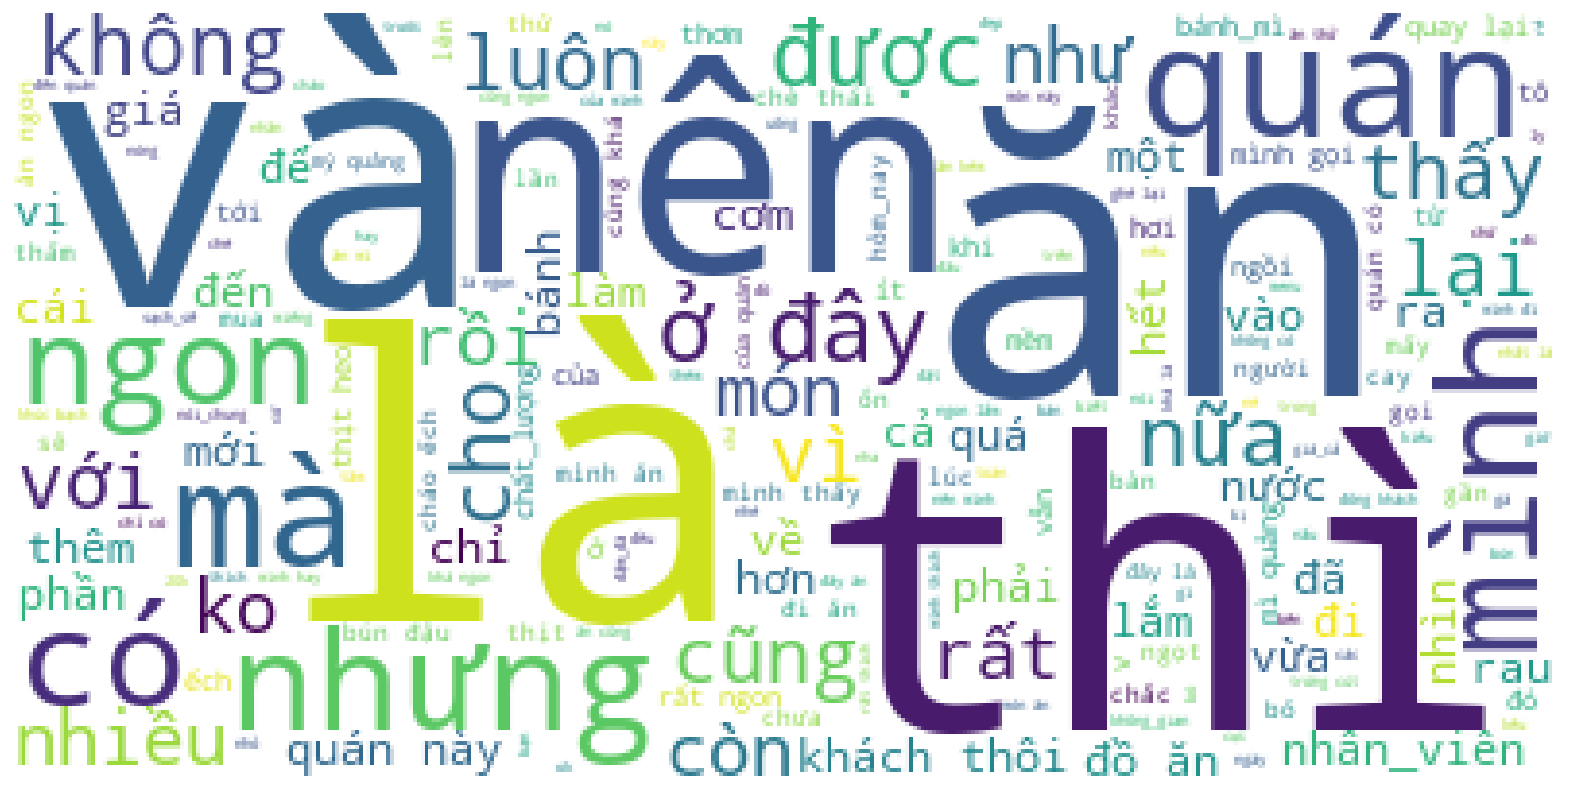

In [94]:
plot_wordcloud(clean_sentences)

In [95]:
clean_negative = clean_df[clean_df['Label'] == 1]
clean_positive = clean_df[clean_df['Label'] == 0]

clean_negative_sentences = " ".join(clean_negative['Review'].tolist())
clean_positive_sentences = " ".join(clean_positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

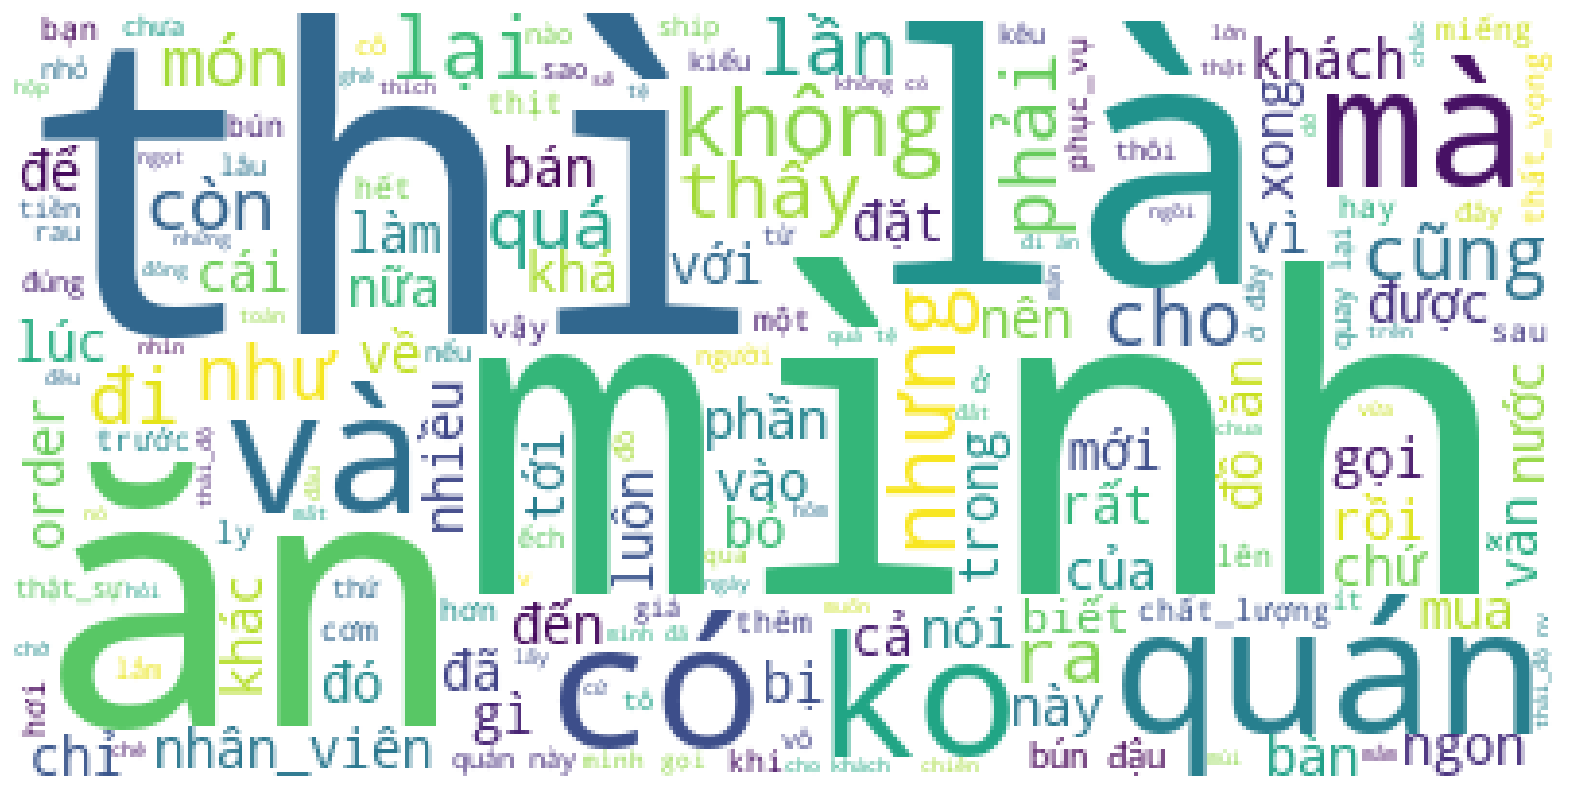

In [96]:
plot_wordcloud(clean_negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

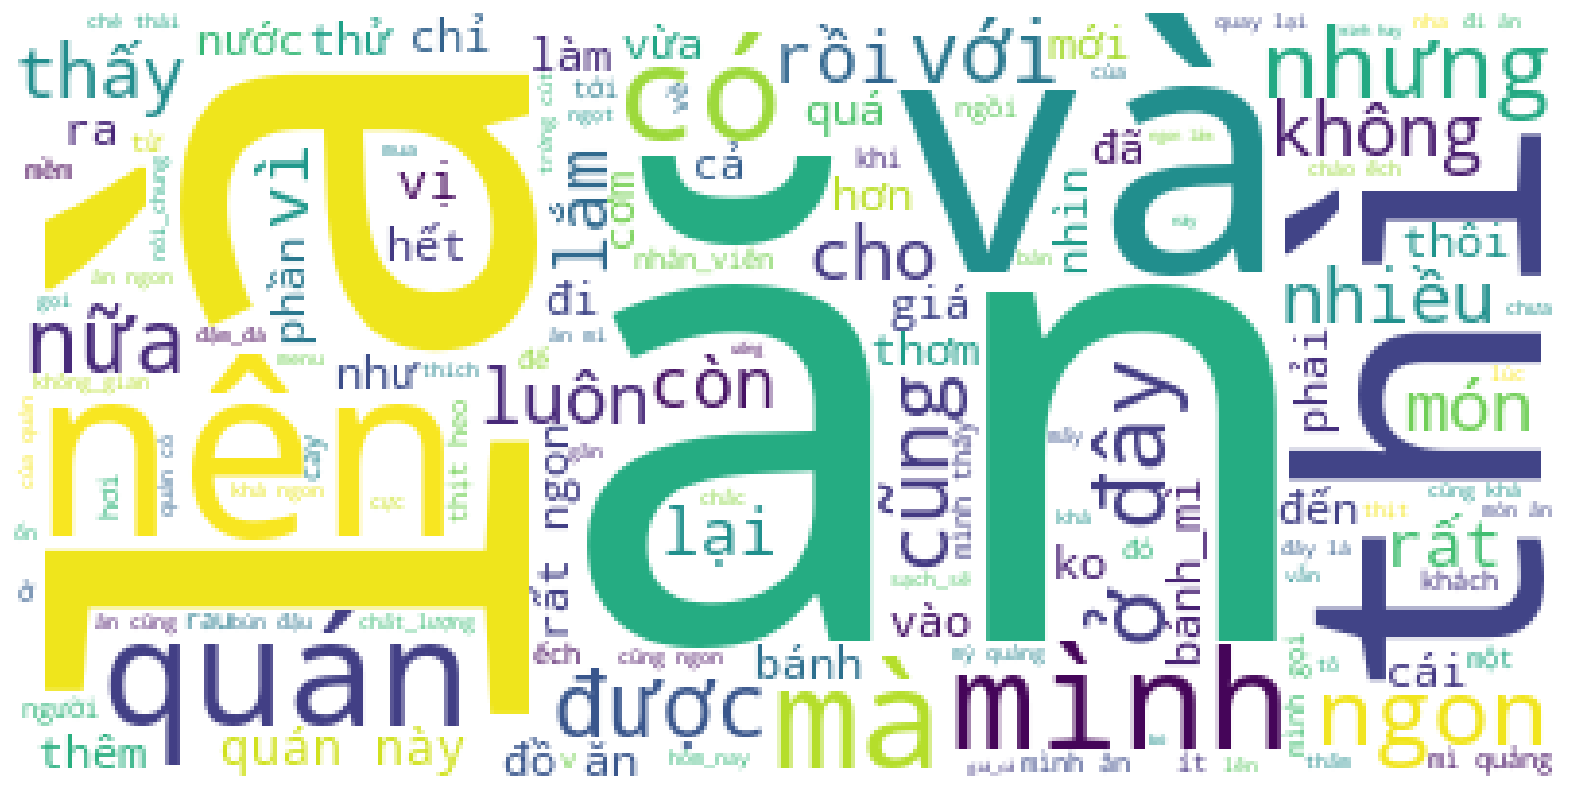

In [97]:
plot_wordcloud(clean_positive_sentences)

## Vector hoá dữ liệu

### CountVectorizer làm input

In [108]:
x = df['Review']
y = df['Label']

In [127]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=review_cleaning)),
    ('classìier', MultinomialNB())
])

y_pred = cross_val_predict(pipeline, x, y, cv=5)

<Axes: >

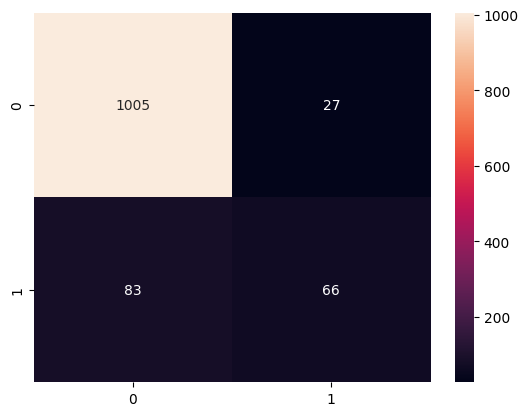

In [128]:
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [129]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1032
           1       0.71      0.44      0.55       149

    accuracy                           0.91      1181
   macro avg       0.82      0.71      0.75      1181
weighted avg       0.90      0.91      0.90      1181

